In [1]:
%pylab inline
import pymaster as nmt
import healpy as hp
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [34]:
mask = hp.read_map("/global/homes/j/jharno/IA-infusion/SkySim5000/FullSky_weight.fits")
#Downgrading mask to reasonable size
mask = hp.ud_grade(mask, 256)

In [35]:
# Read mask and apodize it on a scale of ~1deg
mask = nmt.mask_apodization(mask, 1., apotype="Smooth")

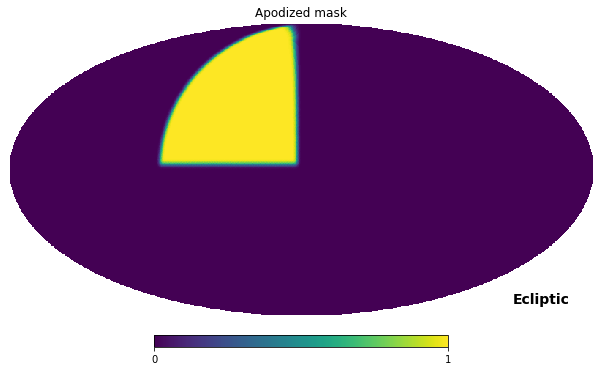

In [36]:
hp.mollview(mask, coord=['E', 'E'], title='Apodized mask')
plt.show()

In [19]:
from astropy.table import Table
# Cool, so now, we need to load a catalog and bin it into healpix maps
catalog = Table.read('/global/cscratch1/sd/jharno/IA_Infusion/GalCat_tomo1_All_0.06GpAM_RA_Dec_g1_g2_w_den_Sij.dat',
                     format='ascii', descriptions=['ra_deg', 'dec_deg', 'shear1', 'shear2', 'weight', 'z_true', 'delta', 's11', 's22', 's12'])

In [37]:
pixels = hp.ang2pix(256, catalog['col1'], catalog['col2'], lonlat=True)

In [44]:
gamma1_map = np.zeros_like(mask)
gamma2_map = np.zeros_like(mask)
counts_map = np.zeros_like(mask)


from tqdm import tqdm
for i in tqdm(range(len(catalog))):
    gamma1_map[pixels[i]] += catalog['col3'][i]
    gamma2_map[pixels[i]] += catalog['col4'][i]
    counts_map[pixels[i]] += 1.
    
gamma1_map[counts_map >0] /= counts_map[counts_map >0]
gamma2_map[counts_map >0] /= counts_map[counts_map >0]

100%|██████████| 1113829/1113829 [00:04<00:00, 268410.13it/s]


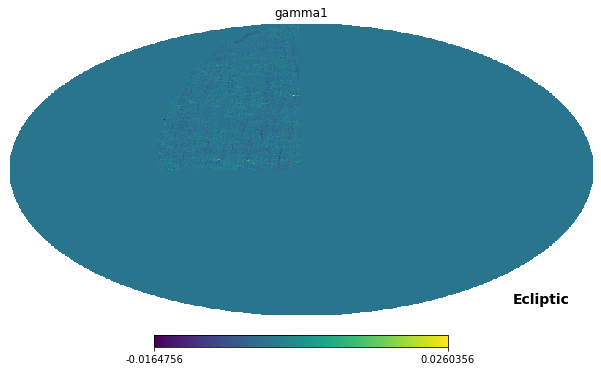

In [45]:
hp.mollview(gamma1_map, coord=['E', 'E'], title='gamma1')
plt.show()

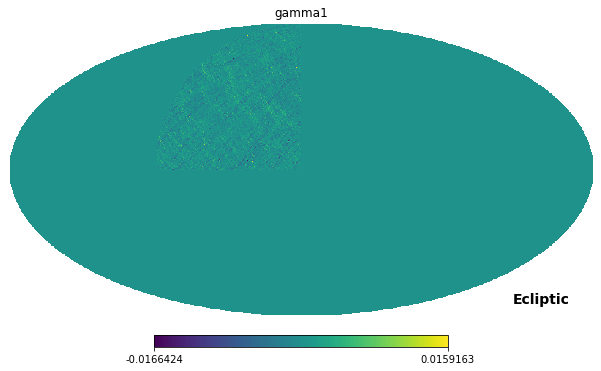

In [46]:
hp.mollview(gamma2_map, coord=['E', 'E'], title='gamma1')
plt.show()

In [48]:
f_2 = nmt.NmtField(mask, [gamma1_map, gamma2_map])

In [50]:
b = nmt.NmtBin.from_nside_linear(256, 4)

In [51]:
cl_22 = nmt.compute_full_master(f_2, f_2, b)

In [52]:
ell_arr = b.get_effective_ells()

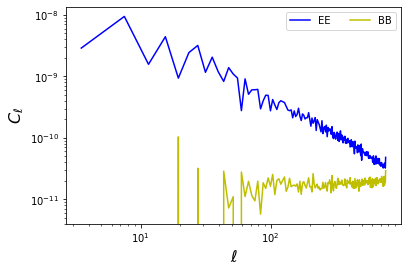

In [59]:
plt.plot(ell_arr, cl_22[0], 'b-', label='EE')
plt.plot(ell_arr, cl_22[3], 'y-', label='BB')
plt.loglog()
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='upper right', ncol=2, labelspacing=0.1)
plt.show()

In [72]:
import pyccl as ccl

cosmo_ccl = ccl.Cosmology(
    Omega_c=0.2648, 
    Omega_b=0.0448,
    h=0.71, 
    sigma8 = 0.801, 
    n_s=0.963, 
    Neff=0)

In [73]:
nzs = np.loadtxt('StageIV_zcen_nz_bin1-5.dat')

In [81]:
# Let's first compute some Weak Lensing cls
tracer_ccl = ccl.WeakLensingTracer(cosmo_ccl, (nzs[:,0], nzs[:,1]), use_A_ia=False)

In [82]:
cl_ccl = ccl.angular_cl(cosmo_ccl, tracer_ccl, tracer_ccl, ell_arr)

Text(0, 0.5, 'Lensing angular $C_\\ell$')

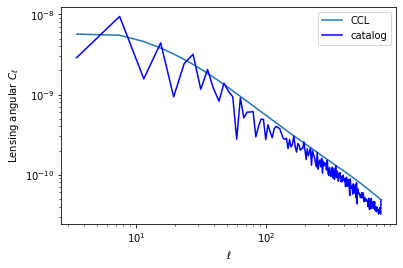

In [83]:
loglog(ell_arr, cl_ccl,label='CCL')
plot(ell_arr, cl_22[0], 'b-', label='catalog')

legend()
xlabel(r'$\ell$')
ylabel(r'Lensing angular $C_\ell$')